In [66]:
%load_ext autoreload
% autoreload 2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='serif')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from geant_dataloader import rtnpy_load_data
from logistics import *
import random
import datetime
import os

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0a0+200fb22


In [76]:
torch.manual_seed(423312)
imageSize = 32
batchSize = 32
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
norm_scale = 'unif'
epoch=0 #will be updated during the run
num_epochs = 30
nc =1
ndf = 64
ngf = 64
nz = 256

In [68]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = '-1to1'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

('Random Seed: ', 25)
Using Cuda
cuda:1
('Using:', 'gpu', 0L)


In [69]:
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
#image_array1 = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npy", num_events = None, image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize)+"ImageSize_800MeV_ScintiAbsoThickness75_8.npy", num_events = None, image_size = imageSize)
#image_array=np.concatenate((image_array1, image_array2),0)

In [70]:
print image_array.shape


(30000, 1, 32, 32)


In [71]:
#print norm_scale
normed_array, scale = normalize(image_array, norm_scale = norm_scale )

tensor_array_train = torch.stack([torch.Tensor(i) for i in normed_array[:20000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i) for i in normed_array[20000:]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=8)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 8)
print(train_loader)

In [72]:
def to_img(x, norm_scale = norm_scale, scale = scale, imageSize=imageSize):
    x = x.cpu().data.numpy()
    #x = 0.5 * (x + 1)
   # print x
   # x = np.clip(x, 0, 1)
    
    # this just drops the channel axis
    x = x.reshape([-1, imageSize, imageSize])

    x = unnormalize(x, scale = scale, norm_scale = norm_scale)
    #print x.max()
    
    return x

def plot_reconstructions(model, save_dir=None, epoch = epoch, n_events = num_epochs, latent_dim = nz, conv=True, simple=False, n=4, norm_scale = norm_scale, batchSize = batchSize, scale = scale):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data= next(iter(test_loader))
    #print(data[0].shape)
    #print norm_scale
    if not conv:
        data = data.view([-1, 4096])
    #data = Variable(data, volatile=True)
    true_imgs = data[0]
    encoded_imgs = model.encoder(data[0].to(device))
    print encoded_imgs.shape
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
    #print(encoded_imgs)    
    decoded_imgs = model.decoder(encoded_imgs)
    #print(decoded_imgs)
    true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
    decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
    print(decoded_imgs.shape)
    
    rowsize = n * 2.5
    columnsize = 4
    fig, axn = plt.subplots(figsize=(rowsize, columnsize))
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)

        if i == 0:
            im = plt.imshow(true_imgs[i], cmap=cmap)
        else: 
            plt.imshow(true_imgs[i], cmap=cmap)
        #if i == 0:
        #    ax.set_ylabel("Real")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        if i == 0:
            ax.set_ylabel("Real", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.25,0.5)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap=cmap)
        print(decoded_imgs[i].min(), decoded_imgs[i][0].max())
        if i == 0:
            ax.set_ylabel("Decoded", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.3,0.5)

        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    fig.subplots_adjust(wspace=-0.185, hspace=0.09)
    fig.suptitle(r"DCVAE Real and Decoded Samples of $e^{-}$ $E_{dep}$, "+ str(latent_dim) + " Latent Dim ", x=0.52, y = 1.02)
          
    if save_dir != None:
        #learning_rate = '%.0E' % Decimal(lr)
      
        filename = "DCVAE_EdepFor" + str(n_events) + "Events_" + str(latent_dim) +"latentDim_"+ str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize"
 
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    
    return

In [77]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)    
    
# class VAE(nn.Module):
#     def __init__(self, image_channels=1, h_dim=2304, z_dim=32):
#         super(VAE, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(image_channels, 32, kernel_size=6, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding = 0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding = 0),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding = 1),
#             nn.ReLU(), # 256 x 2 x 2 = 1024
#             Flatten()
#         )
        
#         self.fc1 = nn.Linear(h_dim, z_dim)
#         self.fc2 = nn.Linear(h_dim, z_dim)
#         self.fc3 = nn.Linear(z_dim, h_dim)
        
#         self.decoder = nn.Sequential(
#             UnFlatten(),
#             nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
#             nn.Sigmoid(),
#         )
        
#     def reparameterize(self, mu, logvar):
#         std = logvar.mul(0.5).exp_()
#         # return torch.normal(mu, std)
#         esp = torch.randn(*mu.size()).to(device)
#         z = mu + std * esp
#         return z
    
#     def bottleneck(self, h):
#         mu, logvar = self.fc1(h), self.fc2(h)
#         z = self.reparameterize(mu, logvar)
#         return z, mu, logvar

#     def encode(self, x):
#         h = self.encoder(x)
#         z, mu, logvar = self.bottleneck(h)
#         return z, mu, logvar

#     def decode(self, z):
#         z = self.fc3(z)
#         z = self.decoder(z)
#         return z

#     def forward(self, x):
#         z, mu, logvar = self.encode(x)
#         z = self.decode(z)
#         return z, mu, logvar

    
    
class VAE32(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE32, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1) , # 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),  # 4 x 4
            nn.BatchNorm2d(128),
            nn.Conv2d(128, nz, 4,2,1),
            #nn.BatchNorm2d(256),
           # nn.Conv2d(256, 10, 1),
            # setup the non-linearity
            nn.ReLU(inplace=True),
            # 256 x 2 x 2 = 1024
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.relu = nn.ReLU()
        
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=6, stride=2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding  = 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding = 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z =self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

ngf = 64
ndf = 64
nc = 1

# class VAE(nn.Module):
#     def __init__(self, nz):
#         super(VAE, self).__init__()

#         self.have_cuda = False
#         self.nz = nz

#         self.encoder = nn.Sequential(
#             # input is (nc) x 28 x 28
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 14 x 14
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 7 x 7
#             nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
#             # nn.BatchNorm2d(1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             # nn.Sigmoid()
#         )

#         self.decoder = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d(     1024, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ngf),
#             # nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
#             # nn.Tanh()
#             nn.Sigmoid()
#             # state size. (nc) x 64 x 64
#         )

#         self.fc1 = nn.Linear(1024, 512)
#         self.fc21 = nn.Linear(512, nz)
#         self.fc22 = nn.Linear(512, nz)

#         self.fc3 = nn.Linear(nz, 512)
#         self.fc4 = nn.Linear(512, 1024)

#         self.lrelu = nn.LeakyReLU()
#         self.relu = nn.ReLU()
#         # self.sigmoid = nn.Sigmoid()

#     def encode(self, x):
#         conv = self.encoder(x);
#         # print("encode conv", conv.size())
#         h1 = self.fc1(conv.view(-1, 1024))
#         # print("encode h1", h1.size())
#         return self.fc21(h1), self.fc22(h1)

#     def decode(self, z):
#         h3 = self.relu(self.fc3(z))
#         deconv_input = self.fc4(h3)
#         # print("deconv_input", deconv_input.size())
#         deconv_input = deconv_input.view(-1,1024,1,1)
#         # print("deconv_input", deconv_input.size())
#         return self.decoder(deconv_input)

#     def reparametrize(self, mu, logvar):
#         std = logvar.mul(0.5).exp_()
#         if self.have_cuda:
#             eps = torch.cuda.FloatTensor(std.size()).normal_()
#         else:
#             eps = torch.FloatTensor(std.size()).normal_()
#         eps = Variable(eps)
#         return eps.mul(std).add_(mu)

#     def forward(self, x):
#         # print("x", x.size())
#         mu, logvar = self.encode(x)
#         # print("mu, logvar", mu.size(), logvar.size())
#         z = self.reparametrize(mu, logvar)
#         # print("z", z.size())
#         decoded = self.decode(z)
#         # print("decoded", decoded.size())
#         return decoded, mu, logvar

In [78]:
#model = ConvolutionalAutoEncoder32(ngpu).to(device)
#optimizer = optim.Adam(model.parameters())


def loss_fn(recon_x, x, mu, logvar):
    #print x.shape
   # print recon_x.shape
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

image_channels = 1
#model = VAE(nz=3).to(device)
model = VAE32(image_channels).to(device)
#model.load_state_dict(torch.load('vae.torch', map_location='cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 



/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/2018-05-30_23-26-23/
torch.Size([32, 1024])
(32, 32, 32)
(68.83491, 85.57974)
(68.23454, 84.948746)
(56.50719, 87.22412)
(68.28872, 85.93663)
(70.8889, 85.84379)


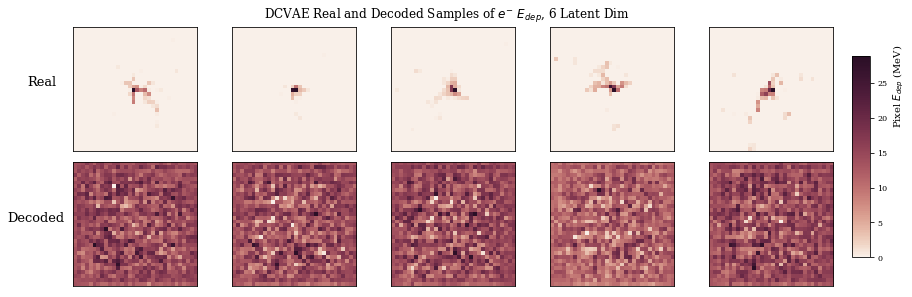

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/50] Loss: 742.984 742.984 0.000
Epoch[2/50] Loss: 5.776 5.734 0.042
Epoch[3/50] Loss: 5.156 5.112 0.044
Epoch[4/50] Loss: 4.967 4.920 0.048
Epoch[5/50] Loss: 4.905 4.853 0.052
torch.Size([32, 1024])
(32, 32, 32)
(2.8983916e-06, 0.80249894)
(4.1141575e-05, 4.463977)
(4.1795196e-05, 3.902862)
(1.0819579e-05, 4.9762545)
(9.661534e-06, 1.6379186)


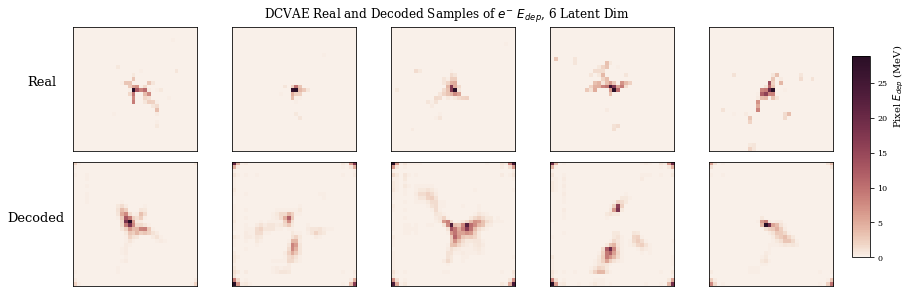

Epoch[6/50] Loss: 4.871 4.817 0.054
Epoch[7/50] Loss: 4.860 4.803 0.056
Epoch[8/50] Loss: 4.832 4.777 0.055
Epoch[9/50] Loss: 4.833 4.776 0.057
Epoch[10/50] Loss: 4.813 4.755 0.058
torch.Size([32, 1024])
(32, 32, 32)
(1.9897385e-05, 0.61135405)
(5.4431006e-05, 2.8627925)
(1.615027e-05, 1.3372363)
(1.2963595e-06, 3.454066)
(7.648212e-06, 1.8881967)


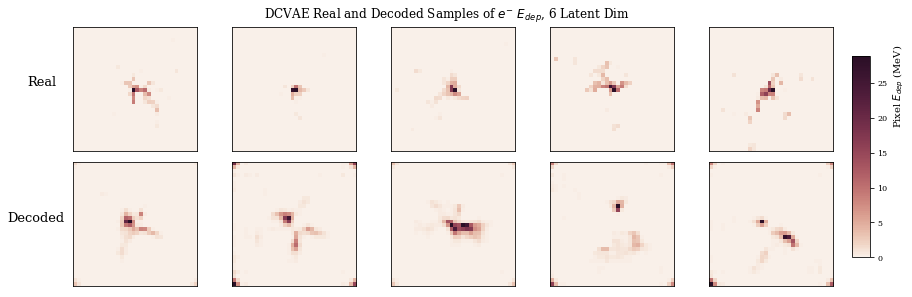

Epoch[11/50] Loss: 4.815 4.758 0.057
Epoch[12/50] Loss: 4.796 4.739 0.058
Epoch[13/50] Loss: 4.813 4.756 0.057
Epoch[14/50] Loss: 4.794 4.737 0.058
Epoch[15/50] Loss: 4.793 4.735 0.058
torch.Size([32, 1024])
(32, 32, 32)
(5.788301e-05, 0.08139021)
(0.000108056985, 2.4325275)
(1.2664458e-05, 2.0580623)
(9.4714105e-06, 3.376569)
(5.572715e-06, 1.7421255)


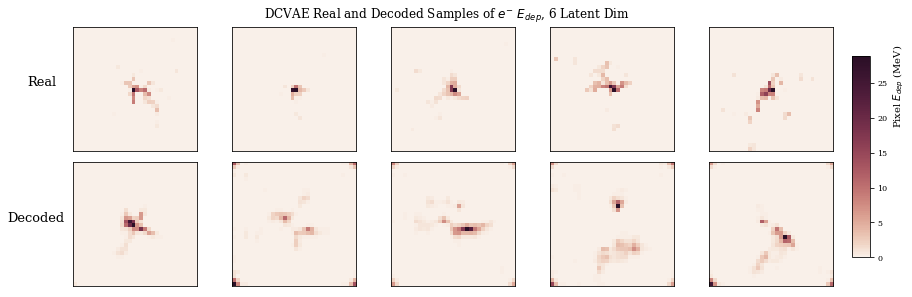

Epoch[16/50] Loss: 4.792 4.733 0.058
Epoch[17/50] Loss: 4.780 4.722 0.058
Epoch[18/50] Loss: 4.769 4.709 0.059
Epoch[19/50] Loss: 4.759 4.699 0.060
Epoch[20/50] Loss: 4.767 4.708 0.059
torch.Size([32, 1024])
(32, 32, 32)
(5.7701625e-05, 0.4091944)
(0.00010785602, 4.4746366)
(4.7419777e-05, 2.6991541)
(5.66917e-06, 3.7793808)
(1.9465104e-05, 2.8535373)


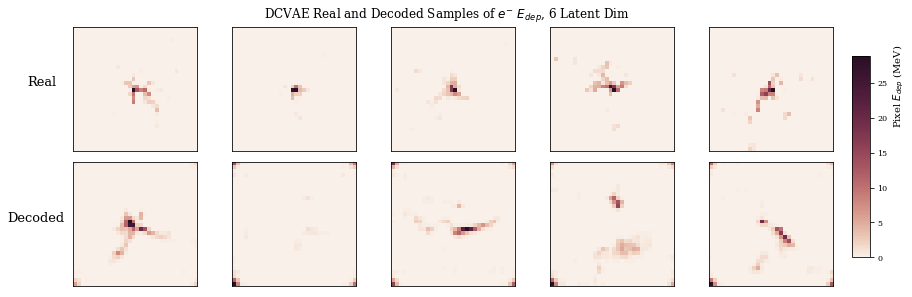

Epoch[21/50] Loss: 4.757 4.698 0.059
Epoch[22/50] Loss: 4.755 4.695 0.059
Epoch[23/50] Loss: 4.751 4.691 0.060
Epoch[24/50] Loss: 4.747 4.686 0.061
Epoch[25/50] Loss: 4.742 4.683 0.060
torch.Size([32, 1024])
(32, 32, 32)
(4.0166804e-05, 1.0084767)
(8.413603e-05, 5.8492613)
(2.8510553e-05, 2.940617)
(2.2489827e-05, 3.371765)
(9.4268225e-06, 2.3268263)


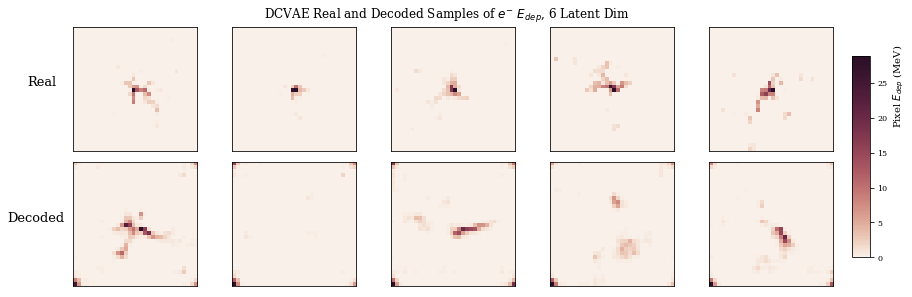

Epoch[26/50] Loss: 4.741 4.680 0.061
Epoch[27/50] Loss: 4.735 4.675 0.060
Epoch[28/50] Loss: 4.737 4.676 0.061
Epoch[29/50] Loss: 4.735 4.674 0.061
Epoch[30/50] Loss: 4.730 4.669 0.061
torch.Size([32, 1024])
(32, 32, 32)
(5.7031182e-05, 1.0459563)
(0.00010158434, 5.0174356)
(2.1237232e-05, 2.5590472)
(1.3840302e-05, 3.7220507)
(2.549761e-05, 1.3736753)


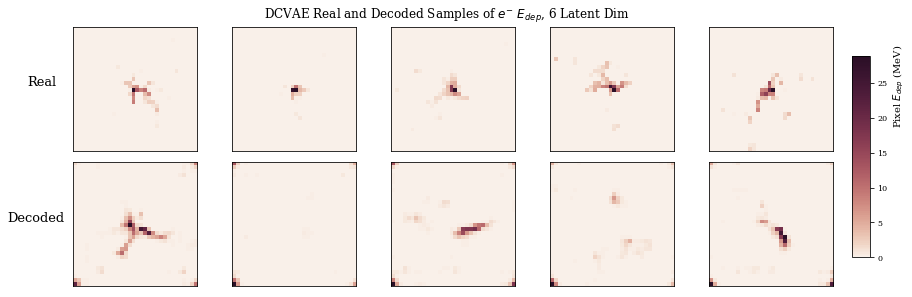

Epoch[31/50] Loss: 4.736 4.675 0.061
Epoch[32/50] Loss: 4.728 4.664 0.063
Epoch[33/50] Loss: 4.723 4.660 0.062
Epoch[34/50] Loss: 4.726 4.663 0.063
Epoch[35/50] Loss: 4.723 4.660 0.063
torch.Size([32, 1024])
(32, 32, 32)
(3.0528867e-05, 0.9753994)
(5.3085703e-05, 4.6755786)
(2.1279908e-05, 1.697662)
(9.176733e-06, 2.1093137)
(1.798987e-05, 1.5552336)


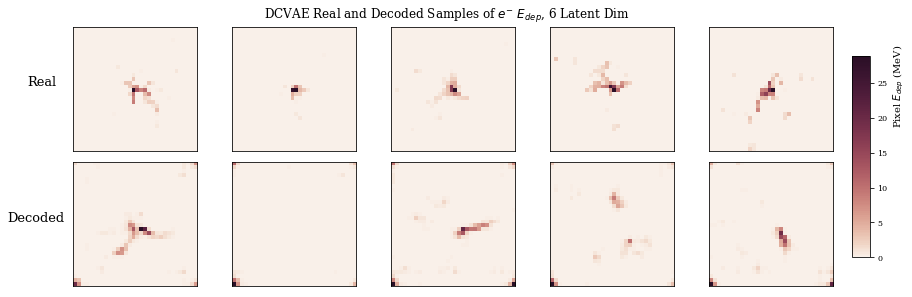

Epoch[36/50] Loss: 4.724 4.660 0.064
Epoch[37/50] Loss: 4.715 4.651 0.064
Epoch[38/50] Loss: 4.713 4.651 0.063
Epoch[39/50] Loss: 4.710 4.647 0.063
Epoch[40/50] Loss: 4.708 4.645 0.063
torch.Size([32, 1024])
(32, 32, 32)
(1.1027211e-05, 0.98322296)
(7.4013304e-05, 4.0233216)
(1.5516642e-05, 0.98795855)
(1.699028e-06, 1.8585907)
(1.3266494e-05, 2.2498531)


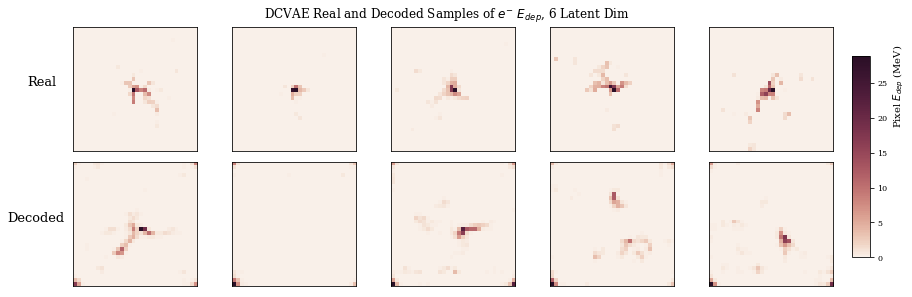

Epoch[41/50] Loss: 4.710 4.647 0.062
Epoch[42/50] Loss: 4.705 4.642 0.063
Epoch[43/50] Loss: 4.706 4.644 0.061
Epoch[44/50] Loss: 4.704 4.642 0.062
Epoch[45/50] Loss: 4.706 4.645 0.062
torch.Size([32, 1024])
(32, 32, 32)
(4.633065e-06, 0.9116231)
(6.385849e-05, 4.795649)
(3.0238729e-05, 2.0489914)
(2.2848187e-06, 2.8635285)
(1.69992e-05, 1.6988977)


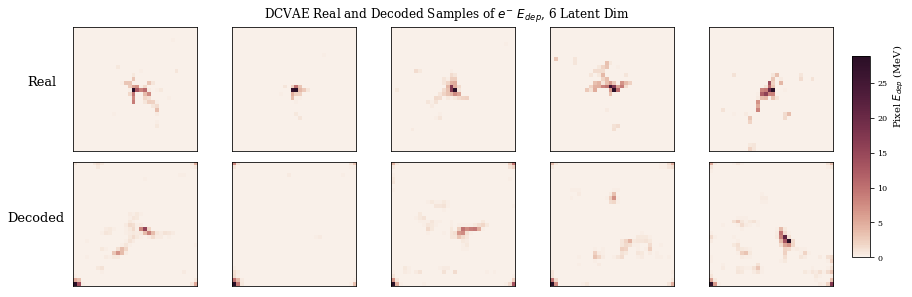

Epoch[46/50] Loss: 4.696 4.633 0.063
Epoch[47/50] Loss: 4.700 4.636 0.064
Epoch[48/50] Loss: 4.700 4.637 0.063
Epoch[49/50] Loss: 4.691 4.627 0.064
Epoch[50/50] Loss: 4.695 4.631 0.064


In [79]:

mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
print(mydir)
# try:
#     os.makedirs(mydir)
# except OSError as e:
#     if e.errno != errno.EEXIST:
#         raise

# with open(mydir + 'NetworkInfo.txt', 'w') as f:
#     print >> f, 'model:', model
epochs = 50    
bs=32
for epoch in range(epochs):
    if epoch % 5 == 0:
        plot_reconstructions(model, save_dir=None, conv=True, simple=False, n=5)
    for idx, data in enumerate(train_loader,0):
        data = data[0].to(device)
        #print data.shape
        recon_images, mu, logvar = model(data)
        loss, bce, kld = loss_fn(recon_images, data, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx == 0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
            print(to_print)


#     plot_reconstructions(model, save_dir=mydir, n=4, conv=True, epoch = epoch, simple=False)
#     train(epoch)

torch.Size([32, 1024])
(32, 32, 32)
(4.800885e-06, 1.1429203)
(6.116056e-05, 5.7024846)
(1.7749855e-05, 1.35134)
(2.3952866e-06, 2.268291)
(1.5933674e-05, 0.84116966)


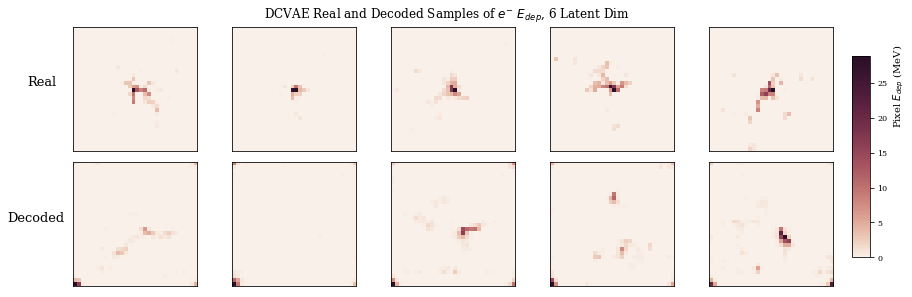

In [80]:
plot_reconstructions(model, save_dir=None, conv=True, simple=False, n=5)

In [ ]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

In [ ]:
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

In [ ]:
combined_fake_image = 0
for i in range(len(decoded_imgs)):
    combined_fake_image += decoded_imgs[i]
combined_fake_image = combined_fake_image / len(true_imgs)

combined_real_image = 0
for i in range(len(true_imgs)):
    combined_real_image += true_imgs[i]
combined_real_image = combined_real_image / len(true_imgs) - 28

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(combined_real_image, cmap ='PuOr')
plt.colorbar(im)

In [ ]:
nz = 10
data = torch.FloatTensor(np.random.uniform(low=0,high=20,size= (batchSize,nz,6,6))).to(device)
#data = torch.randn(batchSize,nz,6,6).to(device)
#print(data)
                 
decoded_imgs = unnormalize(model.decoder(data).cpu().data.numpy().reshape([-1,32,32]),scale=scale,norm_scale=norm_scale)
#print(decoded_imgs)
#true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
#decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
print(decoded_imgs.shape)

n=4
rowsize = n * 2.5
columnsize = 4

fig, ax = plt.subplots(figsize=(rowsize, columnsize))
cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
im = ax.imshow(decoded_imgs[0], cmap=cmap, vmin=0)
plt.colorbar(im)
